In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from scipy.optimize import minimize, basinhopping
from sklearn import preprocessing
import pyfolio as pf
%matplotlib inline

In [2]:
DATA_DIR = 'C:/Users/jgtzsx01/Documents/workspace/zjsxzy_in_js/Research/data/'

In [3]:
fname = '%s/assets2.xlsx'%(DATA_DIR)

In [4]:
odf = pd.read_excel(fname, index_col=0)

In [5]:
odf.head()

,HSCAIT.HI,000852.SH,065.CS,AU9999.SGE,HSCEI.HI,IXIC.GI
2006-01-04,1110.75,852.531,113.2125,138.21,5569.99,2263.46
2006-01-05,1131.49,865.698,113.3975,137.89,5603.94,2276.87
2006-01-06,1138.74,872.818,113.5282,136.81,5677.93,2305.62
2006-01-09,1139.14,886.656,113.6936,140.44,5804.81,2318.69
2006-01-10,1142.14,889.152,113.8044,140.94,5761.62,2320.32


In [6]:
 # 风险预算优化
def calculate_portfolio_var(w, V):
    # 计算组合风险的函数
    return w.dot(V).dot(w)
def calculate_risk_contribution(w ,V):
    # 边际风险贡献
    MRC = V.dot(w)
    # 风险贡献
    RC = w * MRC
    return RC
def risk_budget_objective(x, pars):
    # 计算组合风险
    V = pars[0]# 协方差矩阵
    MRC = V.dot(x)
    ARC = x * MRC
    J = np.sum([(i-j)**2 for i in ARC for j in ARC])
#     J = x.dot(MRC) - np.log(x).sum()
#     J = calculate_portfolio_var(x, V) - np.log(x).sum()
#     J = sum(np.square(asset_RC - risk_target.T))[0, 0] # sum of squared error
#     J = np.abs(asset_RC.max() - asset_RC.min())
    return J
def total_weight_constraint(x):
    return np.sum(x) - 1.0
def long_only_constraint(x):
    return x

In [7]:
# 根据资产预期目标风险贡献度来计算各资产的权重
def calcu_w(V):
    N = V.shape[0]
    w0 = np.random.random_sample((N,))
    w0 /= w0.sum()
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
            {'type': 'ineq', 'fun': long_only_constraint})
    minimizer_args = {'method': 'SLSQP', 'args': [V], 'constraints': cons}
#     minimizer_args = {'method': 'L-BFGS-B', 'args': [V], 'bounds': np.array([(0., None)]*N)}
#     weight = res.x / res.x.sum()
    res = basinhopping(risk_budget_objective, w0, stepsize=1e-8, minimizer_kwargs=minimizer_args)
#     res = minimize(risk_budget_objective, w0, args=[V], method='SLSQP',constraints=cons)
    return res.x

In [8]:
def metric(daily_ret):
    an_ret = pf.empyrical.annual_return(daily_ret)
    sharpe = pf.empyrical.sharpe_ratio(daily_ret)
    vol = pf.empyrical.annual_volatility(daily_ret)
    maxdraw = pf.empyrical.max_drawdown(daily_ret)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

# 情况1
* HSCAIT
* 065.CS
* AU9999.SGE

In [9]:
df = odf[['HSCAIT.HI', '065.CS', 'AU9999.SGE']]

In [10]:
df.head()

,HSCAIT.HI,065.CS,AU9999.SGE
2006-01-04,1110.75,113.2125,138.21
2006-01-05,1131.49,113.3975,137.89
2006-01-06,1138.74,113.5282,136.81
2006-01-09,1139.14,113.6936,140.44
2006-01-10,1142.14,113.8044,140.94


In [12]:
ret_df = df.pct_change().dropna()

In [13]:
months = pd.Series(ret_df.index.map(lambda x: (x.year, x.month)), index=ret_df.index)
rebalance_dates = months.drop_duplicates(keep='last').index

In [14]:
rebalance_dates

DatetimeIndex(['2006-01-25', '2006-02-28', '2006-03-31', '2006-04-28',
               '2006-05-31', '2006-06-30', '2006-07-31', '2006-08-31',
               '2006-09-29', '2006-10-31',
               ...
               '2016-11-30', '2016-12-30', '2017-01-26', '2017-02-28',
               '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-17'],
              dtype='datetime64[ns]', length=140, freq=None)

In [17]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        cov = ret_df[ret_df.index <= date][-242:].cov()
        wb = calcu_w(cov*10000)

In [24]:
weight.drop_duplicates().tail()

,HSCAIT.HI,065.CS,AU9999.SGE
2017-04-05,0.107948,0.791125,0.100927
2017-05-02,0.105639,0.792618,0.101744
2017-06-01,0.120414,0.76765,0.111936
2017-07-03,0.103894,0.780886,0.11522
2017-08-01,0.108612,0.768186,0.123203


In [19]:
portfolio_ret1 = (weight * ret_df).sum(axis=1)

In [20]:
portfolio_ret1 = portfolio_ret1[portfolio_ret1 != 0]

In [21]:
metric(portfolio_ret1)

Annual return: 4.52%
Sharpe ratio: 2.52
Annual volatility: 1.76%
Max drawdown: -3.46%


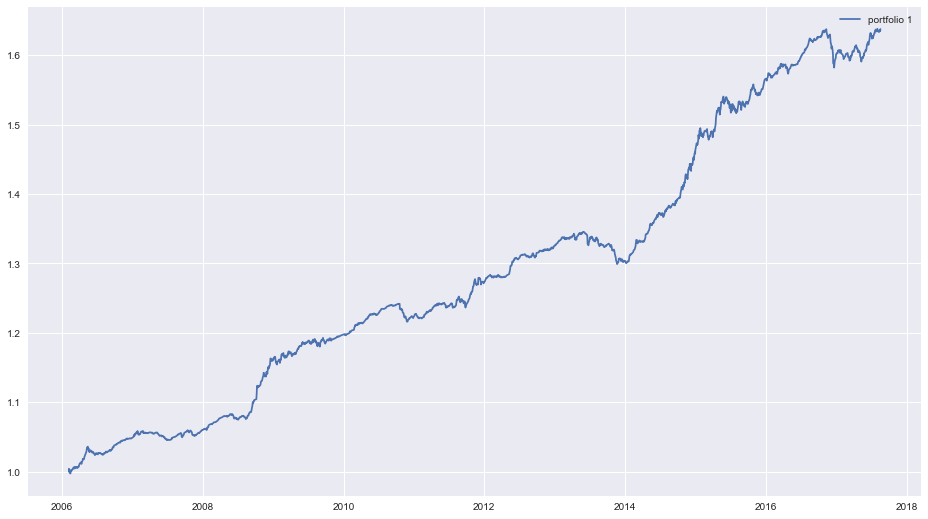

In [23]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret1).cumprod(), label='portfolio 1')
plt.legend()